# Import

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression
import numpy as np
from sklearn.model_selection import GridSearchCV

# Load the data

In [2]:
data = pd.read_csv('merged_data_clean.csv')
data.dropna(subset=["market_value"], inplace=True)

# Clean the data


In [3]:
continent_mapping = {
    'ENG': 'Europe', 'ESP': 'Europe', 'IRL': 'Europe', 'FRA': 'Europe', 'MAR': 'Africa',
    'ALG': 'Africa', 'EGY': 'Africa', 'TUN': 'Africa', 'KSA': 'Asia', 'DEN': 'Europe',
    'BRA': 'South America', 'ITA': 'Europe', 'NGA': 'Africa', 'SCO': 'Europe', 'USA': 'North America',
    'AUT': 'Europe', 'GER': 'Europe', 'CIV': 'Africa', 'MNE': 'Europe', 'SUI': 'Europe',
    'SWE': 'Europe', 'GHA': 'Africa', 'NOR': 'Europe', 'ROU': 'Europe', 'NED': 'Europe',
    'ARG': 'South America', 'PAR': 'South America', 'GAB': 'Africa', 'POR': 'Europe', 'MEX': 'North America',
    'SEN': 'Africa', 'PAN': 'North America', 'PUR': 'North America', 'JAM': 'North America', 'URU': 'South America',
    'VEN': 'South America', 'HAI': 'North America', 'ISL': 'Europe', 'JPN': 'Asia', 'ALB': 'Europe',
    'COL': 'South America', 'TOG': 'Africa', 'IDN': 'Asia', 'GUI': 'Africa', 'CRO': 'Europe',
    'SLE': 'Africa', 'CAN': 'North America', 'COD': 'Africa', 'CMR': 'Africa', 'HUN': 'Europe',
    'ZAM': 'Africa', 'CZE': 'Europe', 'BEL': 'Europe', 'TUR': 'Asia', 'SUR': 'South America',
    'POL': 'Europe', 'SVK': 'Europe', 'GNB': 'Africa', 'SVN': 'Europe', 'MLI': 'Africa',
    'NIR': 'Europe', 'SRB': 'Europe', 'CHI': 'South America', 'WAL': 'Europe', 'AUS': 'Oceania',
    'NZL': 'Oceania', 'ECU': 'South America', 'LUX': 'Europe', 'GAM': 'Africa', 'CGO': 'Africa',
    'BAN': 'Asia', 'EQG': 'Africa', 'CPV': 'Africa', 'GEO': 'Asia', 'MTQ': 'North America',
    'BIH': 'Europe', 'MKD': 'Europe', 'BFA': 'Africa', 'GRE': 'Europe', 'UKR': 'Europe',
    'CRC': 'North America', 'LTU': 'Europe', 'RUS': 'Europe', 'DOM': 'North America', 'IRQ': 'Asia',
    'KOR': 'Asia', 'PHI': 'Asia', 'BEN': 'Africa', 'FIN': 'Europe', 'EST': 'Europe',
    'ZIM': 'Africa', 'ISR': 'Asia', 'CYP': 'Asia', 'UZB': 'Asia', 'ANG': 'Africa',
    'CTA': 'Africa', 'GLP': 'North America', 'MAD': 'Africa', 'PER': 'South America',
    'GUF': 'South America', 'MOZ': 'Africa', 'ARM': 'Asia', 'KVX': 'Europe', 'LBY': 'Africa',
    'BDI': 'Africa', 'KEN': 'Africa', 'COM': 'Africa', 'MDA': 'Europe', 'MSR': 'North America',
    'JOR': 'Asia', 'IRN': 'Asia', 'MLT': 'Europe'
}
def get_continent_from_alpha3(country_alpha3):
    return continent_mapping.get(country_alpha3, None)
data['continent'] = data["Nation"].apply(lambda x: get_continent_from_alpha3(x.split(" ")[-1]) if pd.notna(x) else None)

In [4]:
data.drop(columns=['Nation'],inplace=True)

In [5]:
data = data[data['Pos'] != 'GK']
cols_to_drop = [col for col in data.columns if "stats_keeper" in col or "GK" in col or "(GK)" in col]
data.drop(columns=cols_to_drop, inplace=True)
gk_cols = [
    "PSxG+/-", "CS", "Stp%", "Launch%", "Save%", "Saves", "CS%", "AvgDist",
    "GA90", "GA", "Thr", "D", "PSxG", "SoTA", "AvgLen", "Stp", "/90",
    "PSxG/SoT", "#OPA", "PKm", "PKsv", "#OPA/90", "PKA", "Opp","W","L"
]
data.drop(columns=gk_cols, inplace=True)




In [6]:
data["preferred_foot"] = data["preferred_foot"].map({"Right": 1, "Left": 0})

In [7]:
data.drop(["normalized_player", "normalized_full_name", "full_name", "dob", "Age", "birth_year_y", "Player", "Squad", "Comp", "last_evaluation"], axis=1, inplace=True)

In [8]:
columns_to_drop = [col for col in data.columns if "Pos" in col and col != "Pos"]
data.drop(columns=columns_to_drop, inplace=True)

In [9]:
columns_to_drop = [col for col in data.columns if "Nation" in col and col != "Nation"]
data.drop(columns=columns_to_drop, inplace=True)

In [10]:
columns_to_drop = [col for col in data.columns if "Comp" in col and col != "Comp"]
data.drop(columns=columns_to_drop, inplace=True)

In [11]:
from datetime import datetime
import pandas as pd

def extract_year(val):
    try:
        # Si c'est une année au format "2027", convertir directement
        if str(val).isdigit():
            return int(val)
        # Essayer de parser une date complète (ex: "Jun 30, 2025")
        date = pd.to_datetime(val, errors='coerce')
        if pd.isna(date):
            return None
        return date.year
    except:
        return None

# Appliquer la fonction à chaque ligne
data['contract_year'] = data['club_contract_valid_until'].apply(extract_year)

current_year = 2025
data['years_left'] = data['contract_year'] - current_year
data.drop(columns=['club_contract_valid_until', 'contract_year'], inplace=True)
data.dropna(subset=['years_left'], inplace=True)


In [12]:
columns_to_drop = [col for col in data.columns if "Age" in col]
data.drop(columns=columns_to_drop, inplace=True)

In [13]:
data = data.assign(Pos=data["Pos"].str.split(",")).explode("Pos").reset_index(drop=True)

In [14]:
data = pd.get_dummies(data, columns=["Pos","continent"], prefix=["Pos","continent"], drop_first=True)

In [15]:
cols_to_drop_90 = [
    col for col in data.columns
    if '/90' in col or '90s_' in col or col.endswith('90')
]
data.drop(columns=cols_to_drop_90, inplace=True)




In [16]:
n_samples, n_features = data.shape
print(f"{n_samples} échantillons, {n_features} features")
print(f"Ratio samples/features : {n_samples / n_features:.2f}")



2369 échantillons, 178 features
Ratio samples/features : 13.31


| Catégorie                     | Exemples de colonnes conservées                                                | Description / Rôle dans la modélisation                                               |
|------------------------------|----------------------------------------------------------------------------------|----------------------------------------------------------------------------------------|
| Variable cible                | `market_value`                                                                 | Valeur marchande à prédire (variable de régression).                                  |
| Identité / Caractéristiques  | `height_cm`, `weight_kg`, `preferred_foot`, `weak_foot`, `birth_year_x`        | Données démographiques et morphologiques du joueur.                                   |
| Contrat / Mise à jour        | `years_left`, `value_updated`                                                  | Informations contractuelles : durée restante, date de mise à jour.                   |
| Temps de jeu                 | `Min`, `MP`, `Starts`, `Subs`, `Mn/MP`, `Mn/Start`, `Mn/Sub`, `Min%`, `unSub`   | Quantité et répartition du temps de jeu.                                               |
| Position (one-hot)           | `Pos_DF,MF`, `Pos_FW`, `Pos_MF`, etc.                                           | Postes joués, encodés en variables binaires.                                           |
| Productivité offensive       | `Gls`, `G/Sh`, `G/SoT`, `G-xG`, `xG`, `xA`, `xAG`, `npxG`, `npxG+xAG`, `xG+xAG` | Capacité à marquer et transformer les occasions.                                      |
| Création d’occasions         | `Ast`, `SCA`, `GCA`, `KP`, `A-xAG`                                              | Création de buts et d’actions dangereuses pour l’équipe.                              |
| Jeu de passes                | `Pass`, `Cmp`, `Cmp%`, `PrgP`, `PassLive`, `PassDead`, `Cmp_stats_passing_types`| Qualité de passe, volume et précision, passes progressives.                           |
| Conduite / progression       | `Carries`, `Succ`, `Succ%`, `Dist`, `TotDist`, `PrgC`, `PrgR`, `PrgDist`, `Rec`, `Recov`, `Touches` | Conduites de balle, distance parcourue, récupération.                         |
| Défense / Duels              | `Tkl`, `Tkl%`, `Tkl+Int`, `TklW`, `Tkld`, `Tkld%`, `Won`, `Won%`, `Blocks`, `Int`, `Clr`, `Dis` | Engagement défensif, tacles, interceptions, duels.                           |
| Zones du terrain             | `Att`, `Mid 3rd`, `Def 3rd`, `Att Pen`, `Def Pen`, `1/3`, `PPA`                 | Zones d’intervention préférentielles sur le terrain.                                 |
| Phases / Types d’actions     | `Live`, `Dead`, `CK`, `CPA`, `FK`, `PK`, `PKatt`, `PKwon`, `PKcon`, `TI`, `TO`, `TB`, `Sw` | Types d’actions (jeux arrêtés, penalties, remises en jeu).                      |
| Discipline / Événements      | `CrdY`, `CrdR`, `Fls`, `Fld`, `OG`, `Off`, `On-Off`, `Lost`, `Mis`, `Err`       | Discipline, fautes, erreurs, impact global sur l’équipe.                              |
| Statistiques avancées        | `G+A`, `G+A-PK`, `G-PK`, `np:G-xG`, `xG+/-`, `+/-`                               | Indicateurs combinés et différentiels de performance.                                 |
| Références techniques        | `Rk`, `Born`, `MP_stats_playing_time`, `Min_stats_playing_time`, `Rk_stats_*`   | Colonnes liées à l’origine ou des statistiques de référence internes.                |


# Baseline

In [17]:
nan_ratio = data.isna().mean().sort_values(ascending=False)
print(nan_ratio[nan_ratio > 0])  # Colonnes concernées

G/SoT       0.205150
Mn/Start    0.097932
npxG/Sh     0.075981
Dist        0.075981
SoT%        0.075981
G/Sh        0.075981
Mn/Sub      0.074293
Succ%       0.064162
Tkld%       0.064162
Tkl%        0.059941
Won%        0.038835
Cmp%        0.002955
On-Off      0.001688
dtype: float64


In [18]:
data.shape

(2369, 178)

In [19]:
# Créer une copie du DataFrame sans les lignes contenant des NaN
data_no_nan = data.dropna()
nb_lignes_supprimees = len(data) - len(data_no_nan)
print(f"Nombre de lignes supprimées : {nb_lignes_supprimees}")
print(f"Nombre de lignes restantes : {len(data_no_nan)}")

Nombre de lignes supprimées : 708
Nombre de lignes restantes : 1661


In [20]:
n_samples, n_features = data_no_nan.shape
print(f"{n_samples} échantillons, {n_features} features")
print(f"Ratio samples/features : {n_samples / n_features:.2f}")



1661 échantillons, 178 features
Ratio samples/features : 9.33


In [21]:
X = data_no_nan.drop(columns=['market_value'])
y = data_no_nan['market_value']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.1)

In [22]:


f_vals, p_vals = f_regression(X_train, y_train.ravel())

significant = p_vals < 0.05
print(f"{significant.sum()} features significatives sur {len(p_vals)}")


140 features significatives sur 177


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_29531/3671703684.py:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  f_vals, p_vals = f_regression(X_train, y_train.ravel())


In [23]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Entraînement + CV
ridge = Ridge()
scores = cross_val_score(ridge, X_train, y_train, cv=5, scoring='r2')
print(f"R² moyen (5-fold CV) : {scores.mean():.3f} ± {scores.std():.3f}")

# Fit sur tout le train
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

# Scores sur échelle réelle
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² sur le test : {r2:.3f}")
print(f"RMSE sur le test : {rmse/1e6:.2f} M€")
print(f"MAE sur le test  : {mae/1e6:.2f} M€")


R² moyen (5-fold CV) : 0.635 ± 0.035
R² sur le test : 0.547
RMSE sur le test : 129779808.74 M€
MAE sur le test  : 8.63 M€


In [24]:
from sklearn.model_selection import GridSearchCV

# Définir la grille de paramètres pour Ridge
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100, 1000,2000, 5000, 10000, 20000, 50000, 100000]
}

ridge = Ridge()
grid_search = GridSearchCV(
    ridge,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Meilleur alpha :", grid_search.best_params_['alpha'])
print("Meilleur score (r2, CV) :", grid_search.best_score_)

# Prédictions sur le test set avec le meilleur modèle
best_ridge = grid_search.best_estimator_
y_pred = best_ridge.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"R² sur le test : {r2:.3f}")
print(f"RMSE sur le test : {rmse/1e6:.2f} M€")
print(f"MAE sur le test  : {mae/1e6:.2f} M€")


/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.43331e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.49736e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.55801e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.02092e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrit

Meilleur alpha : 1000
Meilleur score (r2, CV) : 0.6408964000370156
R² sur le test : 0.563
RMSE sur le test : 125032851.55 M€
MAE sur le test  : 8.35 M€


# On limite les grandes valeurs marchandes


In [25]:

param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100, 1000,2000, 5000, 10000, 20000, 50000, 100000]
}

ridge = Ridge()
grid_search = GridSearchCV(
    ridge,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_train, np.log1p(y_train))

print("Meilleur alpha :", grid_search.best_params_['alpha'])
print("Meilleur score (r2, CV) :", grid_search.best_score_)

# Prédictions sur le test set avec le meilleur modèle
best_ridge = grid_search.best_estimator_
y_pred = np.expm1(best_ridge.predict(X_test))

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"R² sur le test : {r2:.3f}")
print(f"RMSE sur le test : {rmse/1e6:.2f} M€")
print(f"MAE sur le test  : {mae/1e6:.2f} M€")


/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.02092e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.43331e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.49736e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.55801e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrit

Meilleur alpha : 10
Meilleur score (r2, CV) : 0.7218825513947816
R² sur le test : 0.645
RMSE sur le test : 101649947.78 M€
MAE sur le test  : 5.36 M€


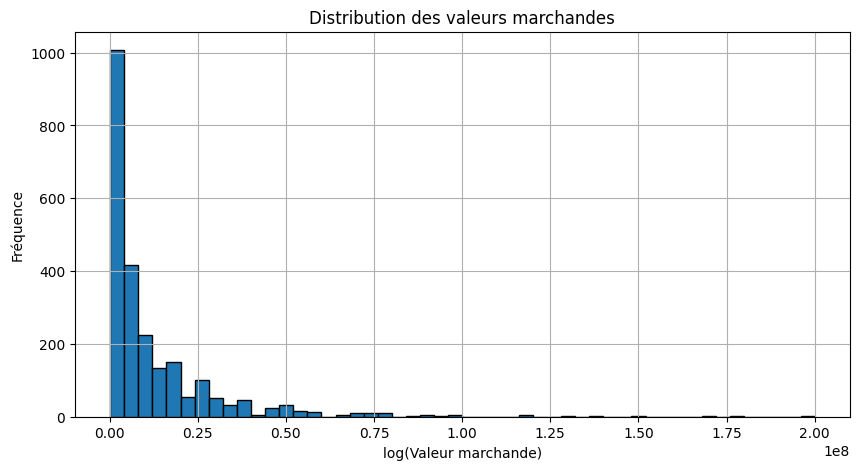

## On teste en clippant

In [26]:
y_train_clipped = np.clip(y_train, 0, 35000000)
y_test_clipped = np.clip(y_test, 0, 35000000)


In [27]:
from sklearn.model_selection import GridSearchCV

# Définir la grille de paramètres pour Ridge
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100, 1000,2000, 5000, 10000, 20000, 50000, 100000]
}

ridge = Ridge()
grid_search = GridSearchCV(
    ridge,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_train, y_train_clipped)

print("Meilleur alpha :", grid_search.best_params_['alpha'])
print("Meilleur score (r2, CV) :", grid_search.best_score_)

# Prédictions sur le test set avec le meilleur modèle
best_ridge = grid_search.best_estimator_
y_pred = best_ridge.predict(X_test)

mae = mean_absolute_error(y_test_clipped, y_pred)
rmse = mean_squared_error(y_test_clipped, y_pred)
r2 = r2_score(y_test_clipped, y_pred)

print(f"R² sur le test : {r2:.3f}")
print(f"RMSE sur le test : {rmse/1e6:.2f} M€")
print(f"MAE sur le test  : {mae/1e6:.2f} M€")


/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.43331e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.02092e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.49736e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.55801e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrit

Meilleur alpha : 10
Meilleur score (r2, CV) : 0.6500843721917428
R² sur le test : 0.655
RMSE sur le test : 44449002.71 M€
MAE sur le test  : 5.19 M€


# On teste les scalers

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Définir le pipeline Ridge avec standardisation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Grille des paramètres pour Ridge (note le nom 'ridge__alpha' à cause du pipeline)
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
}

# GridSearch avec CV à 5 folds
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Entraînement avec target log-transformée
grid_search.fit(X_train, y_train)

# Meilleur modèle trouvé
print("Meilleur alpha :", grid_search.best_params_['ridge__alpha'])
print("Meilleur score (r2, CV) :", grid_search.best_score_)

# Évaluation sur le test set
y_pred = grid_search.predict(X_test) # inverse de log1p
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)  # root MSE
r2 = r2_score(y_test, y_pred)

print(f"R² sur le test : {r2:.3f}")
print(f"RMSE sur le test : {rmse/1e6:.2f} M€")
print(f"MAE sur le test  : {mae/1e6:.2f} M€")




Meilleur alpha : 10
Meilleur score (r2, CV) : 0.6404768098399402
R² sur le test : 0.524
RMSE sur le test : 136331891.89 M€
MAE sur le test  : 8.64 M€


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Définir le pipeline Ridge avec standardisation
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('ridge', Ridge())
])

# Grille des paramètres pour Ridge (note le nom 'ridge__alpha' à cause du pipeline)
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
}

# GridSearch avec CV à 5 folds
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Entraînement avec target log-transformée
grid_search.fit(X_train, y_train)

# Meilleur modèle trouvé
print("Meilleur alpha :", grid_search.best_params_['ridge__alpha'])
print("Meilleur score (r2, CV) :", grid_search.best_score_)

# Évaluation sur le test set
y_pred = grid_search.predict(X_test) # inverse de log1p
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)  # root MSE
r2 = r2_score(y_test, y_pred)

print(f"R² sur le test : {r2:.3f}")
print(f"RMSE sur le test : {rmse/1e6:.2f} M€")
print(f"MAE sur le test  : {mae/1e6:.2f} M€")


Meilleur alpha : 10
Meilleur score (r2, CV) : 0.6384368952811114
R² sur le test : 0.507
RMSE sur le test : 141011843.24 M€
MAE sur le test  : 8.70 M€


# De la merde apres


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Définir le pipeline Ridge avec standardisation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Grille des paramètres pour Ridge (note le nom 'ridge__alpha' à cause du pipeline)
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
}

# GridSearch avec CV à 5 folds
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Entraînement avec target log-transformée
grid_search.fit(X_train, np.log1p(y_train))

# Meilleur modèle trouvé
print("Meilleur alpha :", grid_search.best_params_['ridge__alpha'])
print("Meilleur score (r2, CV) :", grid_search.best_score_)

# Évaluation sur le test set
y_pred = np.expm1(grid_search.predict(X_test)) # inverse de log1p
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)  # root MSE
r2 = r2_score(y_test, y_pred)

print(f"R² sur le test : {r2:.3f}")
print(f"RMSE sur le test : {rmse/1e6:.2f} M€")
print(f"MAE sur le test  : {mae/1e6:.2f} M€")



Meilleur alpha : 1
Meilleur score (r2, CV) : 0.7193136402165157
R² sur le test : 0.625
RMSE sur le test : 107251147.11 M€
MAE sur le test  : 5.50 M€


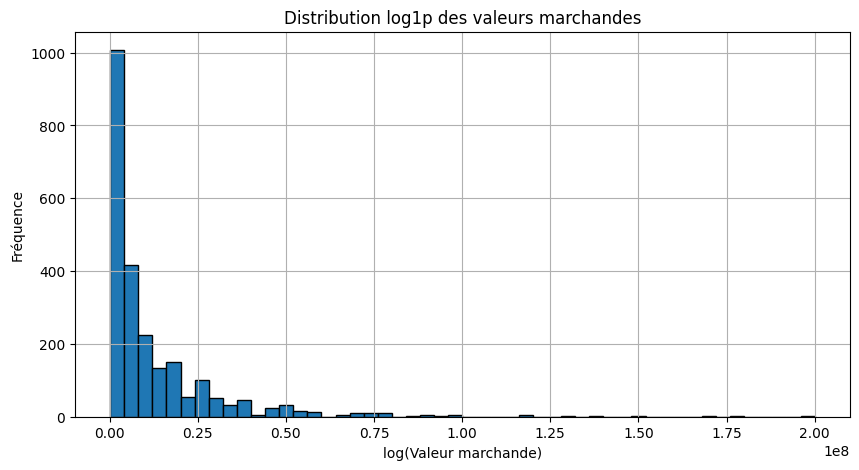

In [31]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.hist(data['market_value'], bins=50, edgecolor='black')
plt.title("Distribution log1p des valeurs marchandes")
plt.xlabel("log(Valeur marchande)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()


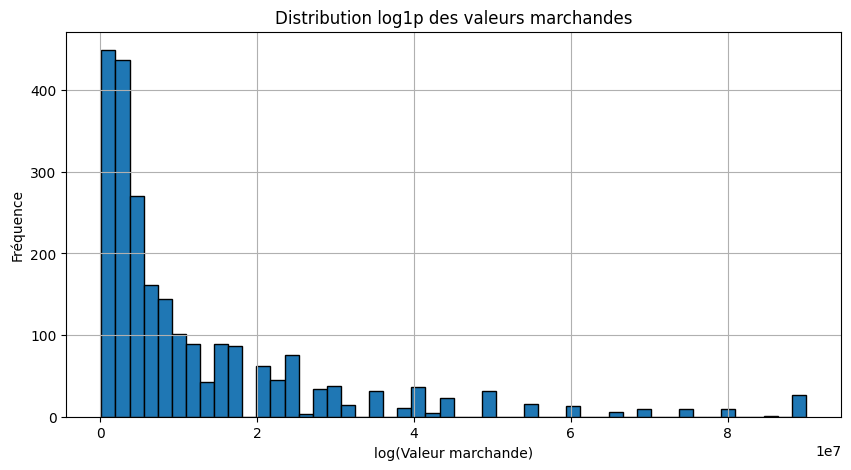

In [32]:
# Clipper au 99e percentile (valeur max ≈ 89.6M)
cap = data['market_value'].quantile(0.99)
data['market_value_clipped'] = data['market_value'].clip(upper=cap)    
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.hist(data['market_value_clipped'], bins=50, edgecolor='black')
plt.title("Distribution log1p des valeurs marchandes")
plt.xlabel("log(Valeur marchande)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()


In [33]:
# Utiliser la colonne 'market_value_clipped' comme cible
X_clip = data_no_nan.drop(columns=['market_value', 'market_value_clipped'], errors='ignore')
y_clip = data_no_nan['market_value_clipped'] if 'market_value_clipped' in data_no_nan else data.loc[data_no_nan.index, 'market_value_clipped']

X_train_clip, X_test_clip, y_train_clip, y_test_clip = train_test_split(X_clip, y_clip, random_state=42, test_size=0.1)

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Pipeline Ridge avec standardisation
pipeline_clip = Pipeline([

    ('ridge', Ridge())
])

# Grille de paramètres pour Ridge
param_grid_clip = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
}

# GridSearchCV
grid_search_clip = GridSearchCV(
    estimator=pipeline_clip,
    param_grid=param_grid_clip,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Entraînement sur la cible "market_value_clipped"
grid_search_clip.fit(X_train_clip, y_train_clip)

print("Meilleur alpha :", grid_search_clip.best_params_['ridge__alpha'])
print("Meilleur score (r2, CV) :", grid_search_clip.best_score_)

# Prédiction sur le test set
y_pred_clip = grid_search_clip.predict(X_test_clip)
mae_clip = mean_absolute_error(y_test_clip, y_pred_clip)
rmse_clip = mean_squared_error(y_test_clip, y_pred_clip)
r2_clip = r2_score(y_test_clip, y_pred_clip)

print(f"Test MAE : {mae_clip:.2f}")
print(f"Test RMSE : {rmse_clip:.2f}")
print(f"Test R² : {r2_clip:.3f}")

/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.02092e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.43331e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.55801e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/alexisletrung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.49736e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrit

Meilleur alpha : 100
Meilleur score (r2, CV) : 0.6656038487207584
Test MAE : 7514051.01
Test RMSE : 100909295942508.36
Test R² : 0.635
